#### Setup

In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
%matplotlib inline
sns.set_theme()

In [498]:
pd.set_option('display.max_columns',None)

In [499]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

# Dataset

### Title: Contraceptive Method Choice  

#### Sources

1. Origin:  This dataset is a subset of:  
  
                 the 1987 National Indonesia  
                Contraceptive Prevalence Survey  
                  

2. Creator: Tjen-Sien Lim (limt@stat.wisc.edu)  
3. Donor:   Tjen-Sien Lim (limt@stat.wisc.edu)  
4. Date:    June 7, 1997
5. Web Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

#### Past Usage

Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of
   Prediction Accuracy, Complexity, and Training Time of Thirty-three
   Old and New Classification Algorithms. Machine Learning. Forthcoming.  
   (ftp://ftp.stat.wisc.edu/pub/loh/treeprogs/quest1.7/mach1317.pdf or
   (http://www.stat.wisc.edu/~limt/mach1317.pdf)

### Description

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey (NICPS), which itself was a part of the larger, annually recurrent National Socioeconomic Survey (popularly called SUSENAS). The samples are married women who were either not pregnant or do not know if they were at the time of interview.  
  
We wish to use the dataset to infer the contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics, with the goal of offering suggestions for further action to address significant social concerns such as child mortality rate, and inform the approach to public health policy and outreach.

- Number of Instances: 1473  
  - Each item in this dataset represents a married female subject of the aforementioned survey
  - Null values: None
- Number of Attributes: 10 (including the class attribute)  
  - Our target variable is `cmc` — contraceptive method used
  - A full breakdown of further attributes is listed in the table below

#### Attributes

       1. Wife's age                 | (numerical)       |
       2. Wife's education           | (categorical)     | 1=low, 2, 3, 4=high
       3. Husband's education        | (categorical)     | 1=low, 2, 3, 4=high
       4. Number of children         | (numerical)       |
       5. Wife's religion            | (binary)          | 0=Non-Islam, 1=Islam
       6. Wife's now working?        | (binary)          | 0=Yes, 1=No
       7. Husband's occupation       | (categorical)     | 1, 2, 3, 4
       8. Standard-of-living index   | (categorical)     | 1=low, 2, 3, 4=high
       9. Media exposure             | (binary)          | 0=Good, 1=Not good
                                     |                   |
           ---------------------     |     ---------     |     ------------
                                     |                   |
                                     |                   |  1=No-use  
       10. Contraceptive method used | (class attribute) |  2=Long-term Method 
                                                         |  3=Short-term Method 

# Cleaning

In [500]:
# Cleaning: setting age minimum to cap at 18
# df['age'] = np.where(df.age < 18,
#                     18,
#                     df.age)

# Cleaning: capping maximum children down to 12
df['chil'] = np.where(df.chil > 11,
                     12,
                     df.chil)

# FE: creating a feature that represents a binary for if wife's education is higher than husband's
df['wife_more_edu'] = np.where(df.edu >= df.hus_edu,
                              1,
                              0)

# FE: creating a feature that represents a binary for women who's education level is the lowest possible while also being not employed.
df['neet'] = np.where((df.edu == 1) 
                    & (df.work == 1),
                         1,
                         0)
# here we set a binary copy of our primary df, for use wherever we want to see ...
y_df = df.copy() # ... any contraceptive use vs. no contraceptive use
y_df['uses_cm'] = np.where(cm_df.cmc == 1, 
                            0, 
                            1)

The following features are categorical and will be one hot encoded in our modeling process:
- Wife's education — `edu`
- Husband's education — `hus_edu`
- Husband's ocupation — `hus_occu`
- Standard-of-living index — `sol`

# EDA

#### Initial

In [501]:
df.columns

Index(['age', 'edu', 'hus_edu', 'chil', 'rel', 'work', 'hus_ocu', 'sol',
       'media', 'cmc', 'wife_more_edu', 'neet'],
      dtype='object')

In [502]:
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
0,24,2,3,3,1,1,2,3,0,1,0,0
1,45,1,3,10,1,1,3,4,0,1,0,1
2,43,2,3,7,1,1,3,4,0,1,0,0
3,42,3,2,9,1,1,3,3,0,1,1,0
4,36,3,3,8,1,1,3,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3,1,0
1469,33,4,4,3,1,1,1,4,0,3,1,0
1470,39,3,3,8,1,0,1,4,0,3,1,0
1471,33,3,3,4,1,0,2,2,0,3,1,0


In [503]:
df.isna().sum() # No null values

age              0
edu              0
hus_edu          0
chil             0
rel              0
work             0
hus_ocu          0
sol              0
media            0
cmc              0
wife_more_edu    0
neet             0
dtype: int64

In [504]:
df.describe()

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.00000
mean,32.538357,2.958588,3.429735,3.257298,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891,0.600136,0.07943
std,8.227245,1.014994,0.816349,2.340784,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376,0.490037,0.27050
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.00000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000,1.000000,0.00000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000,1.000000,0.00000
max,49.000000,4.000000,4.000000,12.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,1.00000


#### TARGET — Contraceptive Method Used — `cmc`

- **Note:** Long-term methods are male or female sterilization, Norplant$_1$ and IUD  
  Short-term methods are all other methods listed in the below table$_2$.  
$_1$: Levonorgestrel-releasing implant  
$_2$: All methods in survey:  
  
        Any method          |  Male sterilization  | Injection
        Pill                | Female sterilization | Diaphragm/foam/jelly 
        Periodic abstinence |       NorpLant       | Condom
        Number of children  |         IUD          | Withdrawal
        Other               |                      | 

In [505]:
df.cmc.value_counts() # values for our target. class imbalance is modest but methods of managing will be evaluated in our modeling process

1    629
3    511
2    333
Name: cmc, dtype: int64

#### Wife's Age — `age`

**Takeaways**:
- The distribution of wives who use no contraception is bimodal, with most in that category aggregating around 25 or 46.  
- The distribution of wives who report long-term contraception use centers around 35.  
- The distribution of wives who report short-term contraception use is right-skewed, with a sharp increase to the mode around age 26, then a steady, tapered decline with age.
- Setting a minimum cap where we impute values below 18 or 19 to that minimum could manage lower sample sizes.
- I might have Freudian slipped right in to choosing the most Georgia O'Keefe plotting style.

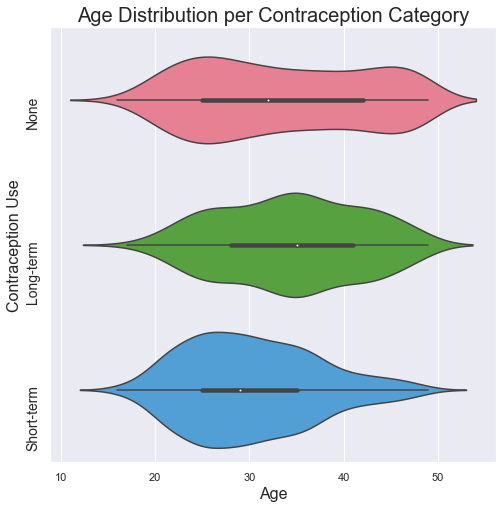

In [506]:
sns.set_palette("husl",3) 
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Age Distribution per Contraception Category', size = 20)
sns.violinplot(x= df.age, y = df.cmc, orient='h')
plt.yticks(np.arange(3), ['None', 'Long-term', 'Short-term'], size = 14, rotation = 90)
ax.set_xlabel('Age', size=16)
ax.set_ylabel('Contraception Use', size=16)
plt.show();

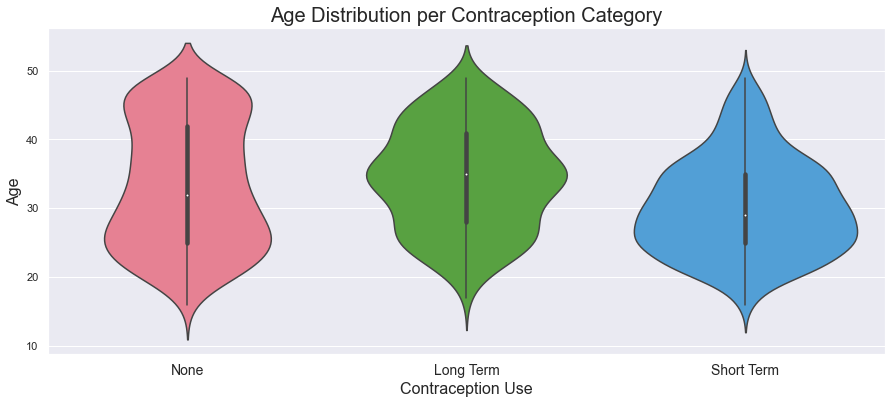

In [507]:
sns.set_palette("husl",3) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Age Distribution per Contraception Category', size = 20)
sns.violinplot(x= df.cmc, y=df.age, orient='v')
plt.xticks(np.arange(3), ['None', 'Long Term', 'Short Term'], size = 14)
ax.set_xlabel('Contraception Use', size=16)
ax.set_ylabel('Age', size=16)
plt.show();

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


''

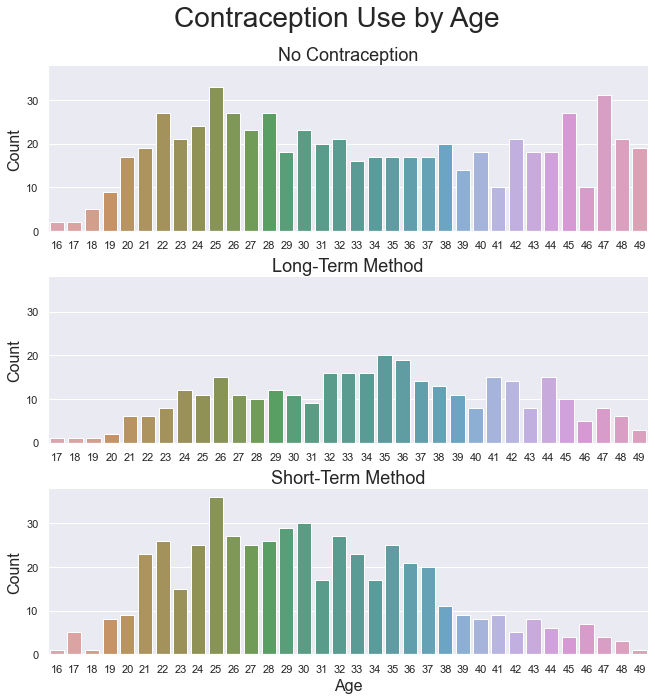

In [508]:
sns.set_palette("cubehelix",24) 
df_age_copy = df.copy()
df_age_copy['cmc'] = df_age_copy['cmc'].map({
    1: "No Contraception", 
    2: "Long-Term Method", 
    3: "Short-Term Method"})
g = sns.catplot(data=df_age_copy, x='age',
                row='cmc', kind = 'count', sharex = False,
                saturation=.5, height=3, aspect=3)
(g.set_axis_labels('Age', 'Count', size=16)
  .set_titles('{row_name}', size=18)
  .fig.suptitle('Contraception Use by Age', size = 28, y = 1.05))
;

In [509]:
df[df.age > 45].age.value_counts()

47    43
48    30
49    23
46    22
Name: age, dtype: int64

In [510]:
df[df.age < 21].age.value_counts()

20    28
19    18
17     8
18     7
16     3
Name: age, dtype: int64

#### Wife's Education — `edu`

Nominal integer values interpretation:
- 1 — did not go to school  
- 2 — some primary school  
- 3 — graduated from primary school with no further education  
- 4 — secondary or higher education. 

**Takeaways**:  
- With higher levels of education achieved, contraception use quite apparently becomes more prevalent.

''

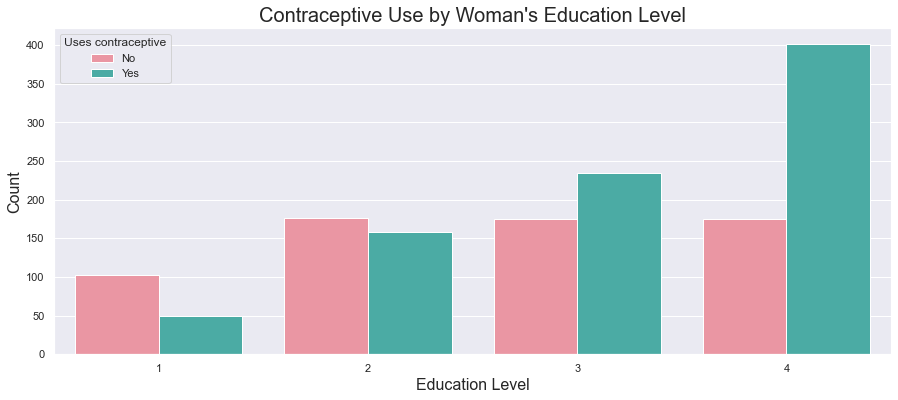

In [511]:
cm_df = df.copy()
cm_df['Uses contraceptive'] = np.where(cm_df.cmc == 1, # mapping multiclass target to a boolean Yes/No value
                            'No',
                            'Yes')

sns.set_palette('cubehelix', 1) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraceptive Use by Woman\'s Education Level', size = 20)
sns.countplot(x='edu',  hue='Uses contraceptive', data=cm_df)
ax.set_xlabel('Education Level',  size=16)
ax.set_ylabel('Count', size=16)
;

Below we explore the relation between a woman's education and the number of children that they've had.

''

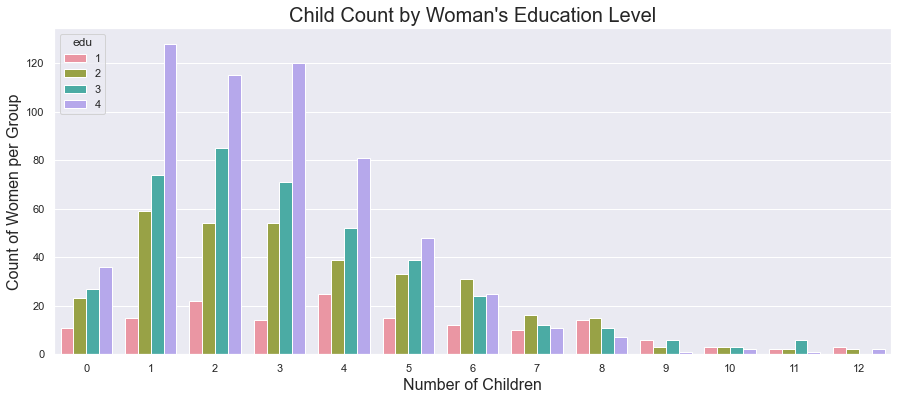

In [512]:
sns.set_palette('cubehelix', 1) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Child Count by Woman\'s Education Level', size = 20)
sns.countplot(x='chil',  hue='edu', data=df)
ax.set_xlabel('Number of Children',  size=16)
ax.set_ylabel('Count of Women per Group', size=16)
;

In [513]:
cm_df.describe()

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.00000
mean,32.538357,2.958588,3.429735,3.257298,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891,0.600136,0.07943
std,8.227245,1.014994,0.816349,2.340784,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376,0.490037,0.27050
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.00000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000,1.000000,0.00000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000,1.000000,0.00000
max,49.000000,4.000000,4.000000,12.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,1.00000


In [514]:
y_df.edu.corr(y_df['uses_cm']) # checking the correlation between education and ANY contraceptive use

0.24476553635585319

In [515]:
df.edu.value_counts()

4    577
3    410
2    334
1    152
Name: edu, dtype: int64

#### Husband's Education — `hus_edu`

Nominal integer values interpretation:
- 1 — did not go to school  
- 2 — some primary school  
- 3 — graduated from primary school with no further education  
- 4 — secondary or higher education. 

In [516]:
df.hus_edu.value_counts()

4    899
3    352
2    178
1     44
Name: hus_edu, dtype: int64

''

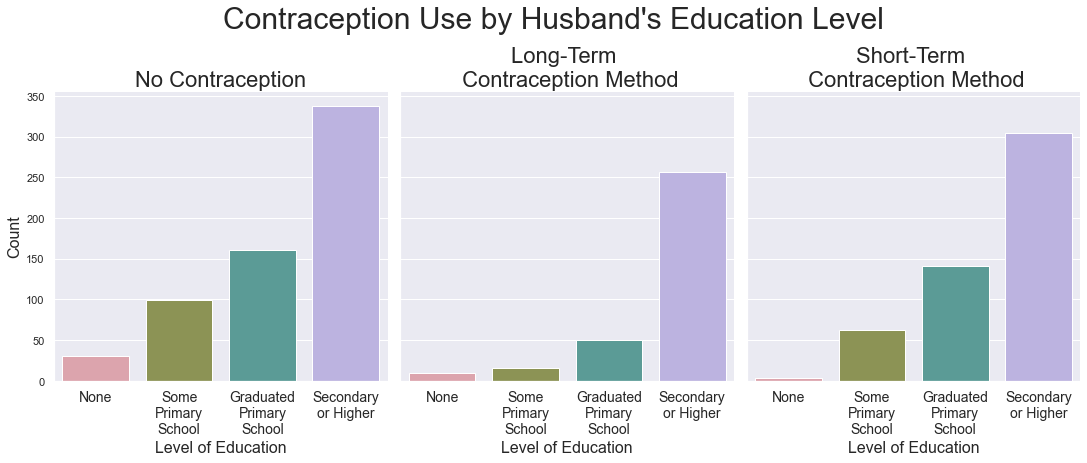

In [517]:
sns.set_palette("husl",3) 
df_hus_edu_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_hus_edu_copy['cmc'] = df_hus_edu_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term \n Contraception Method", 
    3: "Short-Term \n Contraception Method"})

g = sns.catplot(x = 'hus_edu', col = 'cmc', col_wrap = 3, # plotting distributions for different groups of husband's education, with separate plots representing woman of the three classes of contraceptive method 
            data = df_hus_edu_copy, saturation=.5,
            kind = 'count', height=5, aspect=1)
(g.set_axis_labels('Level of Education', 'Count', size=16)
  .set_xticklabels(['None', 'Some\nPrimary\nSchool', 'Graduated\nPrimary\nSchool', 'Secondary\nor Higher'], size = 14)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Husband\'s Education Level', size = 30, y=1.13)
)
;

#### Number of Children — `chil`

**Takeaways**:
- The number of children that a woman has appears to have an effect on their use of contraception. Of all women with no children in the sample, *only two* use any form of contraception.
- all distributions are right-skewed
- outliers may be capped

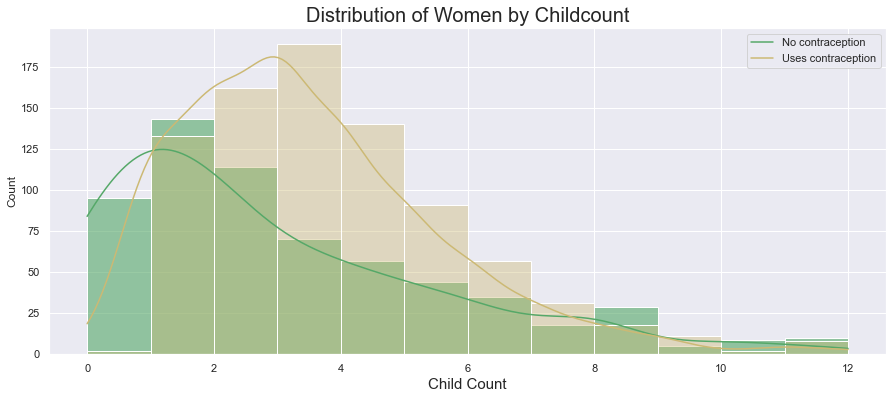

''

In [518]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Women by Childcount', size = 20)
sns.histplot(x = df[df.cmc == 1].chil, bins = 12, kde = True, color = 'g', alpha = .6)
sns.histplot(x = df[df.cmc != 1].chil, bins = 12, kde = True, color = 'y', alpha = .4)
ax.set_xlabel('Child Count', size=15)
ax.legend(labels=['No contraception', 'Uses contraception'])
plt.show()
;

In [519]:
df[df.chil == 0].cmc.value_counts()

1    95
3     2
Name: cmc, dtype: int64

In [520]:
# df[df.chil == 0].cmc.value_counts()
df[(df.chil == 0) & (df.cmc != 1)] # remarkably, of the 97 women with no children, only 2 use any form of contraception

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc,wife_more_edu,neet
942,17,2,2,0,1,0,3,2,0,3,1,0
1443,21,2,2,0,0,1,4,4,0,3,1,0


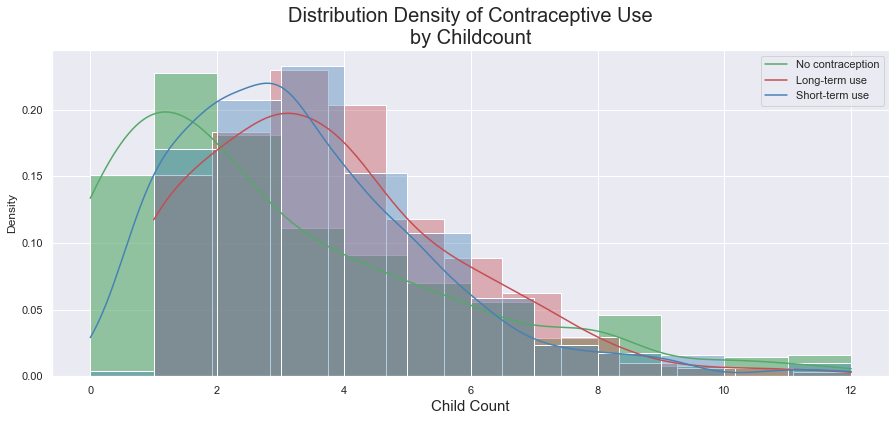

''

In [521]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution Density of Contraceptive Use\nby Childcount', size = 20)
sns.histplot(x = df[df.cmc == 1].chil, bins = 12, kde = True, stat = 'density', color = 'g', alpha = .6)
sns.histplot(x = df[df.cmc == 2].chil, bins = 12, kde = True, stat = 'density', color = 'r', alpha = .4)
sns.histplot(x = df[df.cmc == 3].chil, bins = 12, kde = True, stat = 'density', color = 'steelblue', alpha = .4)
ax.set_xlabel('Child Count', size=15)
ax.legend(labels=['No contraception', 'Long-term use', 'Short-term use'])
plt.show()
;

In [522]:
df[df.chil > 9].chil.value_counts()

11    11
10    11
12     7
Name: chil, dtype: int64

#### Wife's Religion — `rel`

- 1 = Islam
- 0 = Non-Islam  
  
**Takeaways**:
- The distribution of wives by age is more normally distributed for non-Muslim women than Muslim women for the respective classes of contraceptive method.
- The central tendancy for Muslim women who use short-term contraceptive methods is younger amongst Muslim woman than it is for non-Muslim.
- The number of wives in the sample who are Muslim outnumber those that are not by roughly: 6:1

In [523]:
df[df.chil > 9 ].cmc.values # checking the use of contraception among women with a higher range of children

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3])

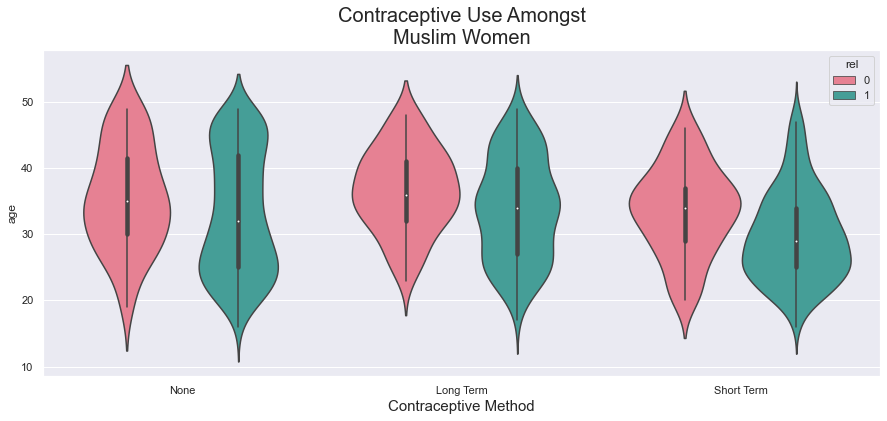

In [524]:
sns.set_palette("husl",2) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraceptive Use Amongst\nMuslim Women', size = 20)
sns.violinplot(x = df.cmc, y = df.age, orient = 'v',
               hue = df.rel, scale_hue = False)
plt.xticks(np.arange(3), ['None', 'Long Term', 'Short Term'])
ax.set_xlabel('Contraceptive Method', size=15)
plt.show();

In [525]:
df[df.rel == 1].cmc.value_counts() # value counts for contraceptive method classes among Muslim women

1    554
3    442
2    257
Name: cmc, dtype: int64

In [526]:
df.rel.value_counts() # class imbalance of roughly 6:1 Muslim to non-Muslim

1    1253
0     220
Name: rel, dtype: int64

#### Wife's Current Emplyment Status — `work`

- 1 — No
- 0 — Yes  
  
**Takeaways**:
- binary categorical
- Class Imbalanced of roughly: 3:1, not employed to employed

''

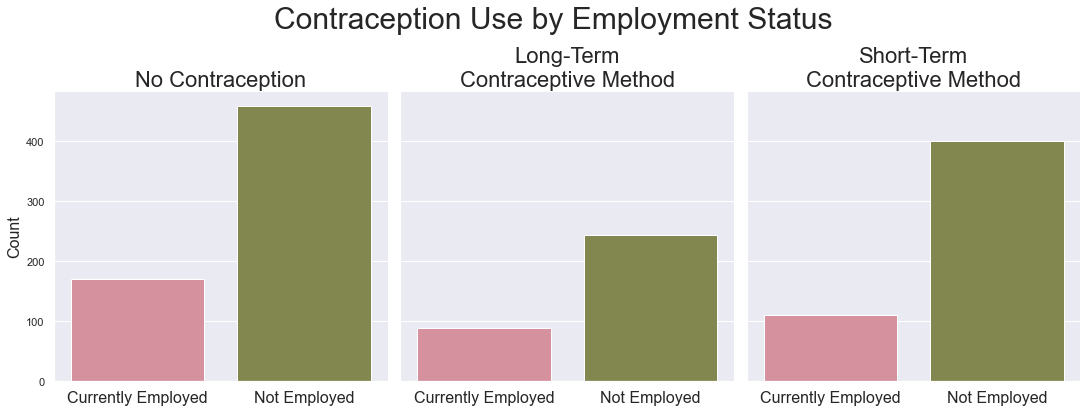

In [527]:
sns.set_palette("husl",4) 
df_work_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_work_copy['cmc'] = df_work_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term\nContraceptive Method", 
    3: "Short-Term\nContraceptive Method"})

g = sns.catplot(x="work", col="cmc", col_wrap=3, # plotting distributions for different groups of women's employment status, with separate plots representing woman of the three classes of contraceptive method 
            data=df_work_copy, saturation=.5,
            kind="count", height=5, aspect=1)
(g.set_axis_labels("", "Count", size=16)
  .set_xticklabels(['Currently Employed', 'Not Employed'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Employment Status', size = 30, y=1.13)
)
;

In [528]:
df.work.value_counts()

1    1104
0     369
Name: work, dtype: int64

In [529]:
# df[(df.work == 1) & (df.cmc == 1)].cmc.value_counts()
# df[(df.work == 1) & (df.cmc == 3)].cmc.value_counts()
# df[(df.work == 1) & (df.cmc == 2)].cmc.value_counts()
# df[(df.work == 0) & (df.cmc == 1)].cmc.value_counts()
# df[(df.work == 0) & (df.cmc == 3)].cmc.value_counts()
df[(df.work == 0) & (df.cmc == 2)].cmc.value_counts()

2    89
Name: cmc, dtype: int64

In [530]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

#### Husband's Occupation — `hus_ocu`

- 1 — PROFESSIONAL, TECHNICAL AND CLERICAL
- 2 — SALES, SERVICES
- 3 — MANUAL 
- 4 — AGRICULTURE
- 5 — OTHER

**Takeaways**:
- Numerical values for this category are in fact **categorical** and must be dummied. 
  - While it is confusing as to which number truly represents which category in our dataset (as we are missing one number listed in the survey description), there is no need to impute.  
  - Unfortunately, uncertainty about which category of occupation each nominal integer represents will make it difficult to offer suggestions for further action relating to this category.

''

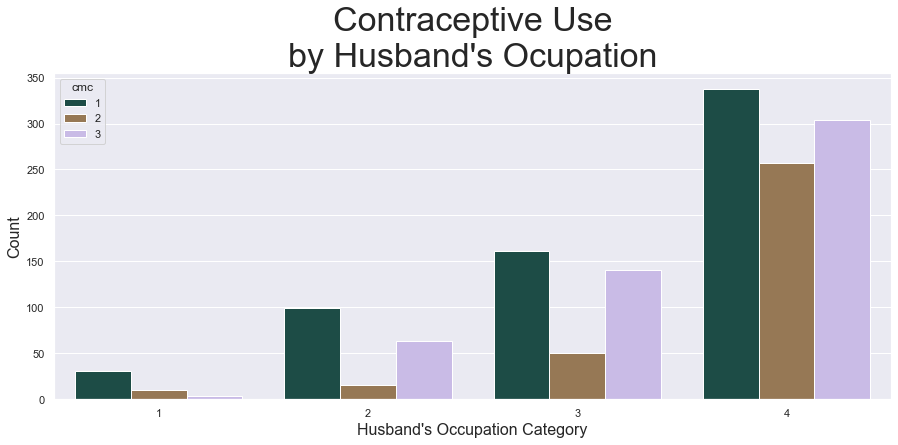

In [531]:
sns.set_palette('cubehelix', 3) 
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraceptive Use\nby Husband\'s Ocupation', size = 34)
sns.countplot(x='hus_edu',  hue='cmc', data=df)
ax.set_xlabel('Husband\'s Occupation Category',  size=16)
ax.set_ylabel('Count', size=16)
;

In [532]:
df.hus_ocu.value_counts()

3    585
1    436
2    425
4     27
Name: hus_ocu, dtype: int64

#### Standard-of-living Index — `sol`

- Standard-of living index ranging from 1 (low) to 4 (high).
- Short-term contraceptive methods seem to be more preferable or accessible than long-term contraceptive methods for people who rate lower on the standard of living index

''

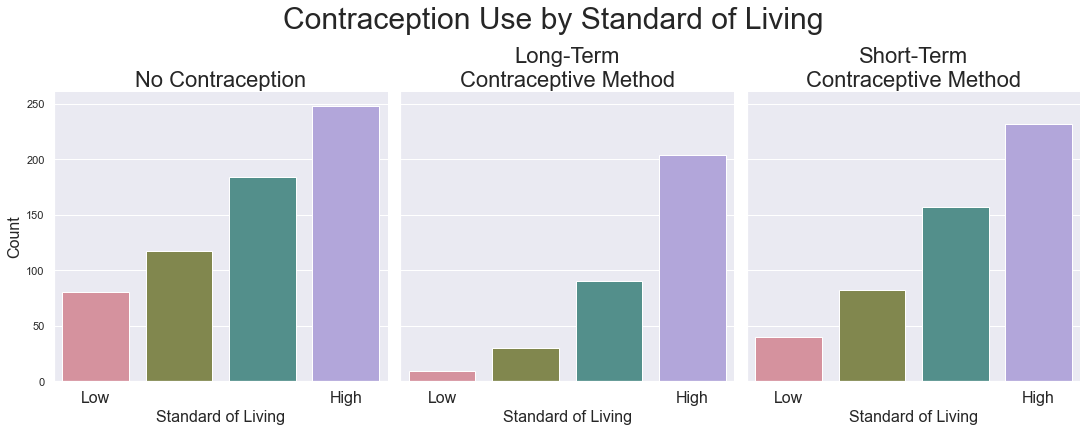

In [533]:
sns.set_palette("husl",4) 
df_sol_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_sol_copy['cmc'] = df_sol_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term\nContraceptive Method", 
    3: "Short-Term\nContraceptive Method"})

g = sns.catplot(x = 'sol', col = 'cmc', col_wrap = 3, # plotting distributions grouped by standard of living, with separate plots representing woman of the three classes of contraceptive method 
            data = df_sol_copy, saturation=.5,
            kind = 'count', height=5, aspect=1)
(g.set_axis_labels('Standard of Living', 'Count', size=16)
  .set_xticklabels(['Low', '', '', 'High'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Standard of Living', size = 30, y=1.13)
)
;

In [534]:
df.sol.value_counts()

4    684
3    431
2    229
1    129
Name: sol, dtype: int64

#### Media Exposure —`media`

- According to the survey, the qualifiers for having "good" media exposure is as follows: 

      Ever-married women who usually read a newspaper once a week, watch television once a week, or listen to a radio daily by background characteristics, NICPS, 1987  
  
- 0 — Good
- 1 — Not good  
  
**Takeaways**:
- Binary categorical. 
- Class imbalance of about: 13:1, good media exposure to not good
  - A great majority of women in this survey have good media exposure. 

''

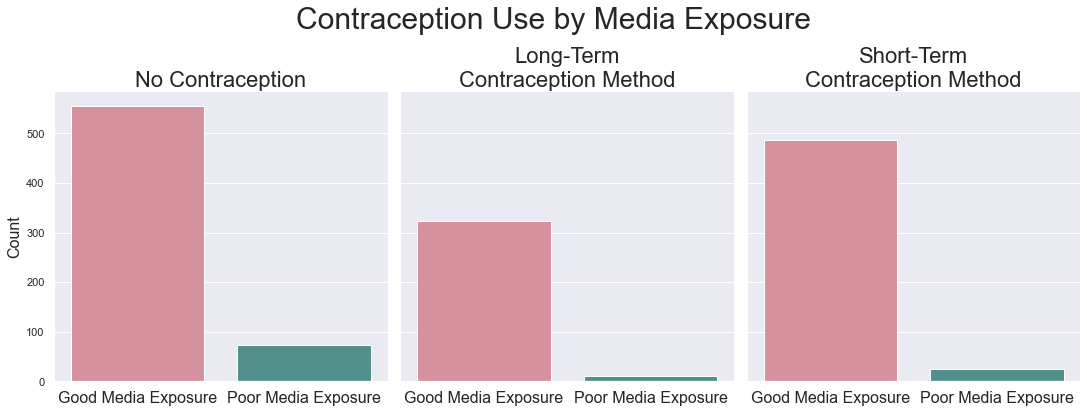

In [535]:
sns.set_palette("husl",2) 
df_media_copy = df.copy() # We make a copy of the original dataframe for unique categorical plots
df_media_copy['cmc'] = df_media_copy['cmc'].map({ # Here we map the nominal integers to a string of their respective categorical interpretation
    1: "No Contraception", 
    2: "Long-Term\nContraception Method", 
    3: "Short-Term\nContraception Method"})

g = sns.catplot(x="media", col="cmc", col_wrap=3, # plotting distributions grouped by media exposure, with separate plots representing woman of the three classes of contraceptive method 
            data=df_media_copy, saturation=.5,
            kind="count", height=5, aspect=1)
(g.set_axis_labels("", "Count", size=16)
  .set_xticklabels(['Good Media Exposure', 'Poor Media Exposure'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Media Exposure', size = 30, y=1.13)
)
;

In [536]:
df.media.value_counts()

0    1364
1     109
Name: media, dtype: int64

#### Pair Plots

Pair plots allow for bivariate feature values to be evaluated against each other for the entire dataset.  
  
**Takeaways**:  
- While it may look pretty, there isn't much information to be gleened from below that isn't better represented in plots above.

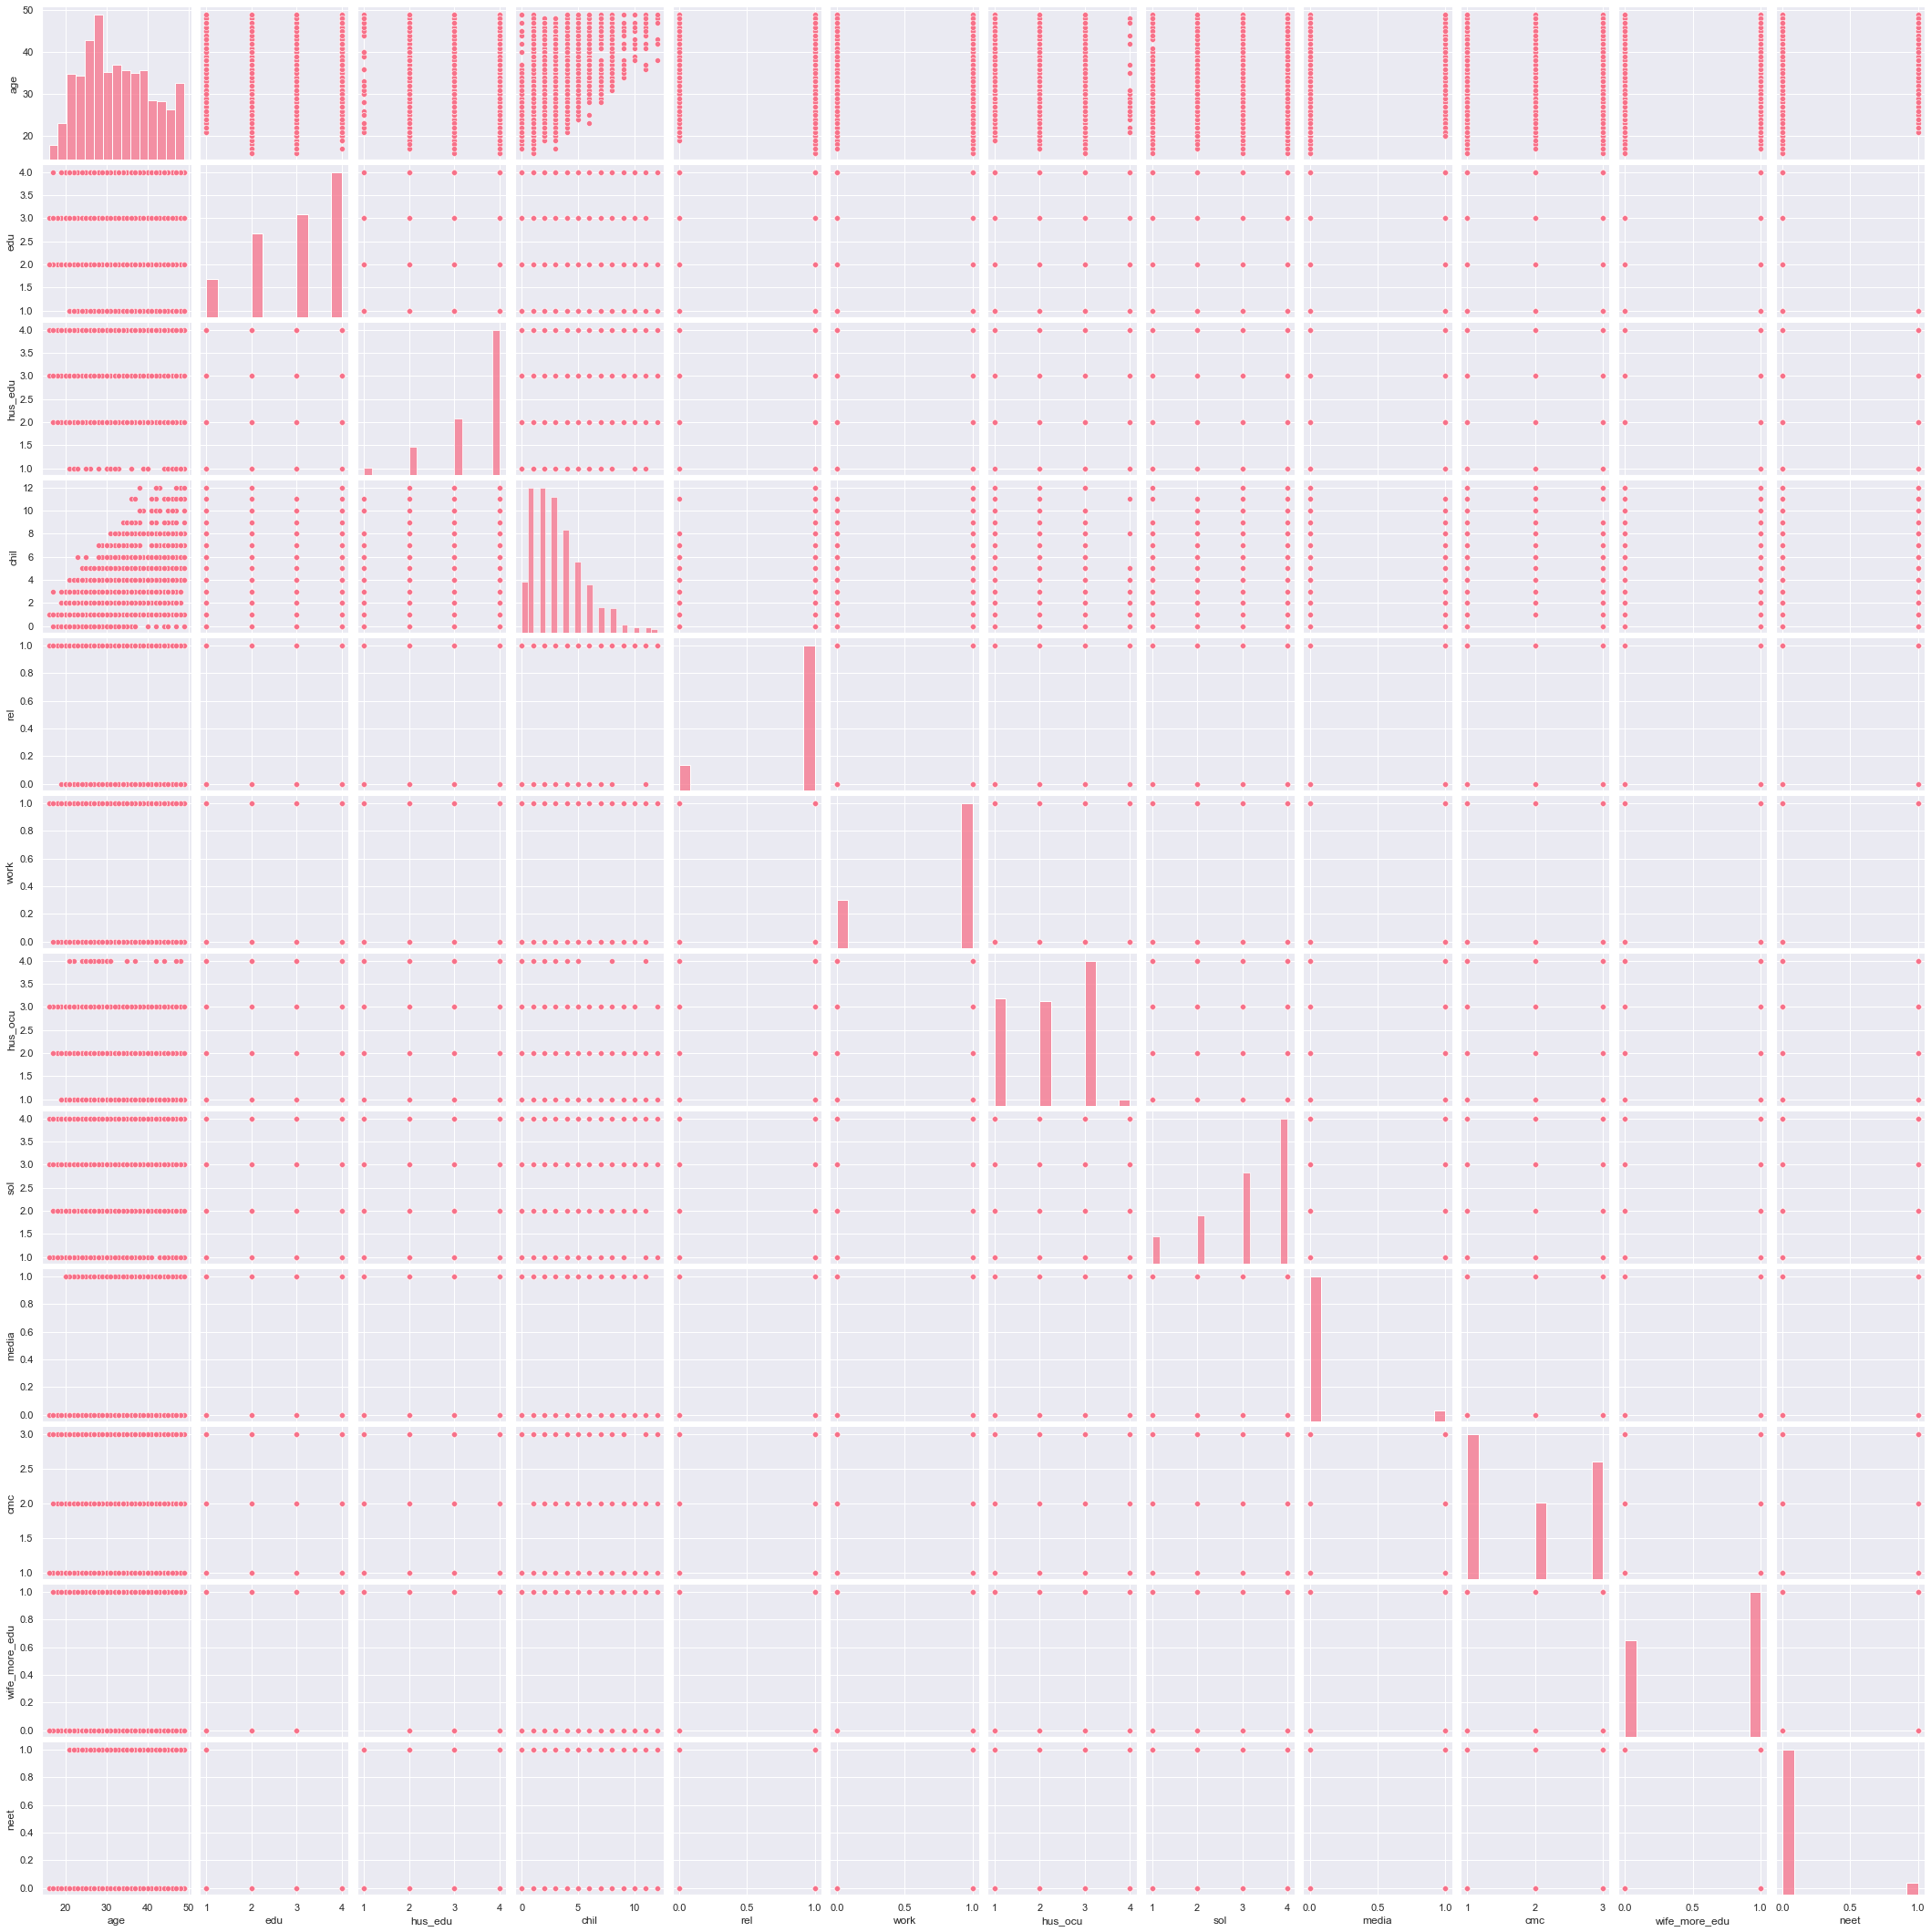

In [537]:
sns.pairplot(df);

## Further Research

In [538]:
addtl = pd.read_csv('data/variables-03-30-21-034145.csv')
addtl

,survey_idno,sid,file_id,vid,name,labl,var_intrvl,var_dcml,var_wgt,var_start_pos,var_end_pos,var_width,var_imputation,var_security,var_respunit,var_qstn_preqtxt,var_qstn_qstnlit,var_qstn_postqtxt,var_qstn_ivulnstr,var_universe,var_sumstat,var_txt,var_catgry,var_codinstr,var_concept,var_format,var_notes
0,IDN_1987_DHS_v01_M,1398,F5,V80,caseid,Case identification,discrete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],NaN,[],"{""type"":""character"",""schema"":""other"",""category...",NaN


In [539]:
birth_var = pd.read_csv('data/variables-03-30-21-034408.csv')
birth_var

,survey_idno,sid,file_id,vid,name,labl,var_intrvl,var_dcml,var_wgt,var_start_pos,var_end_pos,var_width,var_imputation,var_security,var_respunit,var_qstn_preqtxt,var_qstn_qstnlit,var_qstn_postqtxt,var_qstn_ivulnstr,var_universe,var_sumstat,var_txt,var_catgry,var_codinstr,var_concept,var_format,var_notes
0,IDN_1987_DHS_v01_M,1398,F5,V81,bidx,Birth column number,discrete,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],NaN,[],"{""type"":""numeric"",""schema"":""other"",""category"":...",NaN


In [109]:
xml = read_xml('.xml')

NameError: name 'read_xml' is not defined

In [111]:
import xml.etree.ElementTree as ET

xml_data = open('data/IDN_1987_DHS_v01_M.xml', 'r').read()  # Read file
root = ET.XML(xml_data)  # Parse XML

data = []
cols = []
for i, child in enumerate(root):
    data.append([subchild.text for subchild in child])
    cols.append(child.tag)

xml_df = pd.DataFrame(data).T  # Write in DF and transpose it
xml_df.columns = cols  # Update column names
xml_df

,{http://www.icpsr.umich.edu/DDI}docDscr,{http://www.icpsr.umich.edu/DDI}stdyDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}dataDscr
0,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n
1,None,\n,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n
2,None,\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
3,None,\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
371,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
372,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
373,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n


# Feature Engineering

From the attributes present in the sample dataset, have created the following features:
- `wife_more_edu` — Engineered from `edu` and `hus_edu`, reprents if the wife's education level is at least as high as the husband's.
- `neet` — Engineered from `edu` and `work` (acronym borrowed from '*not educated, employed or in training*', though we are not certain if the training part happens to be the case).

In [352]:
df.columns

Index(['age', 'edu', 'hus_edu', 'chil', 'rel', 'work', 'hus_ocu', 'sol',
       'media', 'cmc', 'wife_more_edu'],
      dtype='object')

In [495]:
df.wife_more_edu.value_counts()

1    884
0    589
Name: wife_more_edu, dtype: int64

In [364]:
df[(df.edu == 1) & (df.work == 1) & (df.media == 1)].cmc.value_counts()

1    36
3     9
2     1
Name: cmc, dtype: int64

- Below we evaluate the r$^2$ score between the middle value for age and the contraceptive method used. Were the r$^2$ score to be higher at the middle age, we would create a new feature `midpoint_age` representing the age where women transitioned from being unlikely to use contraception to likely to use a contraceptive method. The results reveal that the likelihood of use is highest towards the later ages from the sample, so no feature will be engineered.

49 0.16295261509293912


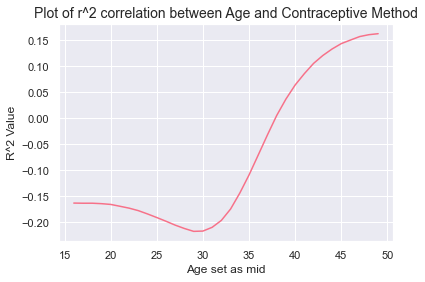

In [540]:
r_df = df.copy() 
r_values = {}
ages = range(r_df.age.min(), r_df.age.max() + 1)
for age in ages:
    r_df['age_mid'] = np.abs(r_df['age'] - age)
    r_values[age] = r_df['age_mid'].corr(r_df.cmc)
    
# Plotting the r^2 correlation between the middle age value and contraceptive method
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Age and Contraceptive Method', fontdict = {'fontsize': 14})
ax.set_xlabel('Age set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key = r_values.get), max(r_values.values()))

# Modeling

#### One Hot Encoding

In [ ]:

# FE: dummy wife's education categories

df = pd.get_dummies(df, columns=['ed'], drop_first=True)

# FE: dummying husband's education categories

df = pd.get_dummies(df, columns=['hus_edu'], drop_first=True)

# FE: dummying husband's occupation categories

df = pd.get_dummies(df, columns=['hus_ocu'], drop_first=True)

# FE: dummying Standard-of-living index categories

df = pd.get_dummies(df, columns=['sol'], drop_first=True)

# possible cleaning... should we switch

In [ ]:
logreg_model_final = LogisticRegression(random_state=20,
                                        solver="liblinear", C=.001, class_weight = 'balanced')